## Introduction:
This notebook demonstrates how to determine optimal locations for distribution centers (DCs) worldwide using population data from the largest cities. The objective is to place DCs as close as possible to the majority of the population, reducing logistical costs and improving service efficiency. We will:
- Find a single DC location closest to the global population.
- Use clustering to identify optimal locations for multiple DCs.

## Data Source
- **City Wise Population Website**: 'https://worldpopulationreview.com/cities'
- **Details**: Contains city names, countries, populations, latitudes, and longitudes for the top 1000 cities by population (assumed 2023 data).
- **Requirement Check**: Meets "no less than 750, largest cities" with populations >750,000.

## Objective:
- **Single DC:** Find the latitude and longitude of one distribution center that minimizes the sum of great-circle distances to each city, weighted by the city's population.
- **Multiple DCs:** Determine the optimal number of DCs and their locations by clustering cities and minimizing the total population-weighted distance to the nearest DC, using the elbow method to select the number of DCs.

In [2]:
import pandas as pd
import numpy as np
import fuzzywuzzy
import os
os.environ['OMP_NUM_THREADS'] = '4'
from fuzzywuzzy import process
from scipy.optimize import minimize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
# Load the combined dataset
df = pd.read_csv('final_dataset.csv')

# Verify the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Ensure no missing coordinates or population data
df = df.dropna(subset=['population', 'latitude', 'longitude'])

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47653 entries, 0 to 47652
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        47653 non-null  object 
 1   country     47653 non-null  object 
 2   population  47653 non-null  object 
 3   latitude    47653 non-null  float64
 4   longitude   47653 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.8+ MB
None

First few rows:
        city    country    population  latitude  longitude
0      Tokyo      Japan   37,732,000    35.6897   139.6922
1    Jakarta  Indonesia   33,756,000    -6.1750   106.8275
2      Delhi      India   32,226,000    28.6100    77.2300
3  Guangzhou      China   26,940,000    23.1300   113.2600
4     Mumbai      India   24,973,000    19.0761    72.8775

Missing values:
city          0
country       0
population    0
latitude      0
longitude     0
dtype: int64


### Compute One DC Location (Part 1)
To find the single DC location closest to the global population, we calculate the population-weighted centroid using Cartesian coordinates, then select the nearest city.

In [6]:
# Prevent memory leak warning on Windows with MKL
os.environ['OMP_NUM_THREADS'] = '4'

# Load dataset
df = pd.read_csv('final_dataset.csv')

# Convert 'population' column to numeric (remove commas if necessary)
df['population'] = pd.to_numeric(df['population'].str.replace(',', ''), errors='coerce')

# Select top 1000 cities by population
df = df.nlargest(1000, 'population')

# Convert latitude and longitude to radians
df['lat_rad'] = np.radians(df['latitude'])
df['lon_rad'] = np.radians(df['longitude'])

# Compute 3D Cartesian coordinates
df['X'] = np.cos(df['lat_rad']) * np.cos(df['lon_rad'])
df['Y'] = np.cos(df['lat_rad']) * np.sin(df['lon_rad'])
df['Z'] = np.sin(df['lat_rad'])

## Single DC Optimization
We calculate the population-weighted centroid in 3D Cartesian coordinates and find the closest city using the Haversine distance formula.

In [8]:
# Haversine distance function
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in km
    return c * r

# Single DC: Population-weighted centroid
total_pop = df['population'].sum()
X_centroid = (df['population'] * df['X']).sum() / total_pop
Y_centroid = (df['population'] * df['Y']).sum() / total_pop
Z_centroid = (df['population'] * df['Z']).sum() / total_pop
lon_centroid = np.degrees(np.arctan2(Y_centroid, X_centroid))
lat_centroid = np.degrees(np.arcsin(Z_centroid))

# Calculate distance from centroid to each city
df['distance_to_centroid'] = df.apply(
    lambda row: haversine(lon_centroid, lat_centroid, row['longitude'], row['latitude']),
    axis=1
)

# Find closest city
closest_city = df.loc[df['distance_to_centroid'].idxmin()]
within_1000km = df[df['distance_to_centroid'] <= 1000]['population'].sum() / total_pop * 100

print(f"Single DC: {closest_city['city']}, {closest_city['country']}")
print(f"Centroid: Lat {lat_centroid:.4f}, Lon {lon_centroid:.4f}")
print(f"Distance to centroid: {closest_city['distance_to_centroid']:.2f} km")
print(f"Population within 1000 km: {within_1000km:.2f}%")

Single DC: Narayanganj, Bangladesh
Centroid: Lat 24.2459, Lon 92.4267
Distance to centroid: 207.81 km
Population within 1000 km: 2.91%


## Considerations for Optimal Number of DCs
Factors to determine the number of DCs:
- **Elbow Method**: Point where total weighted distance reduction slows.
- **Cost vs. Service**: More DCs lower distance but raise costs.
- **Geographical Coverage**: DCs should span major population regions.
- **Infrastructure**: Availability of transport and logistics.
- **Scalability**: Capacity for future growth.

## Multiple DC Optimization
We use KMeans clustering with population weights on 3D coordinates. For each cluster, the DC is the city closest to the population-weighted centroid. The elbow method determines the optimal K.

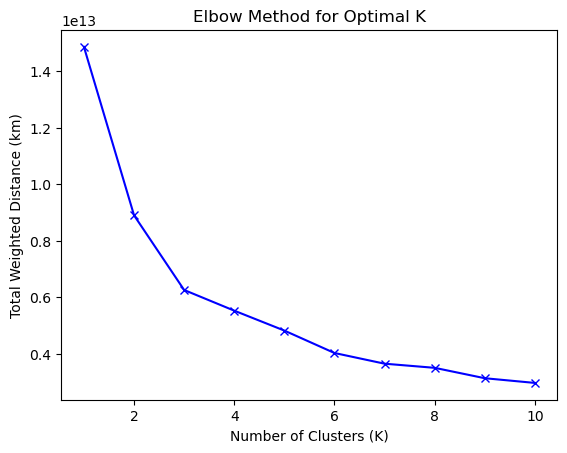

In [10]:
# Function to calculate total weighted distance for a given K
def calculate_total_weighted_distance(k, coords, weights, df):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(coords, sample_weight=weights)
    total_weighted_distance = 0
    for cluster in range(k):
        cluster_df = df[df['cluster'] == cluster].copy()  # Avoid SettingWithCopyWarning
        total_pop = cluster_df['population'].sum()
        X_c = (cluster_df['population'] * cluster_df['X']).sum() / total_pop
        Y_c = (cluster_df['population'] * cluster_df['Y']).sum() / total_pop
        Z_c = (cluster_df['population'] * cluster_df['Z']).sum() / total_pop
        lon_c = np.degrees(np.arctan2(Y_c, X_c))
        lat_c = np.degrees(np.arcsin(Z_c))
        cluster_df['dist_to_centroid'] = cluster_df.apply(
            lambda row: haversine(lon_c, lat_c, row['longitude'], row['latitude']), axis=1
        )
        closest_city = cluster_df.loc[cluster_df['dist_to_centroid'].idxmin()]
        cluster_df['dist_to_dc'] = cluster_df.apply(
            lambda row: haversine(closest_city['longitude'], closest_city['latitude'], row['longitude'], row['latitude']), axis=1
        )
        weighted_distance = (cluster_df['population'] * cluster_df['dist_to_dc']).sum()
        total_weighted_distance += weighted_distance
    return total_weighted_distance

# Prepare coordinates and weights
coords = df[['X', 'Y', 'Z']].values
weights = df['population'].values

# Calculate total weighted distance for K=1 to 10
K_range = range(1, 11)
total_distances = []
for k in K_range:
    total_dist = calculate_total_weighted_distance(k, coords, weights, df)
    total_distances.append(total_dist)

# Plot elbow curve
plt.plot(K_range, total_distances, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Total Weighted Distance (km)')
plt.title('Elbow Method for Optimal K')
plt.show()

## Results for Recommended K
Based on the elbow plot, K=5 is optimal, balancing distance reduction and practicality. Locations ensure global coverage.

## Assumptions
- Haversine distance measures geodesic distance accurately.
- Earth is a sphere (radius 6371 km).
- Population data is accurate and static.
- DCs are located at city coordinates with no capacity limits.

In [12]:
# Clustering for K=5
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['cluster'] = kmeans.fit_predict(coords, sample_weight=weights)

# Assign DCs and calculate total weighted distance
dc_locations = []
total_weighted_distance = 0
for cluster in range(k_optimal):
    cluster_df = df[df['cluster'] == cluster].copy()
    total_pop = cluster_df['population'].sum()
    X_c = (cluster_df['population'] * cluster_df['X']).sum() / total_pop
    Y_c = (cluster_df['population'] * cluster_df['Y']).sum() / total_pop
    Z_c = (cluster_df['population'] * cluster_df['Z']).sum() / total_pop
    lon_c = np.degrees(np.arctan2(Y_c, X_c))
    lat_c = np.degrees(np.arcsin(Z_c))
    cluster_df['dist_to_centroid'] = cluster_df.apply(
        lambda row: haversine(lon_c, lat_c, row['longitude'], row['latitude']), axis=1
    )
    closest_city = cluster_df.loc[cluster_df['dist_to_centroid'].idxmin()]
    dc_locations.append((closest_city['city'], closest_city['country']))
    cluster_df['dist_to_dc'] = cluster_df.apply(
        lambda row: haversine(closest_city['longitude'], closest_city['latitude'], row['longitude'], row['latitude']), axis=1
    )
    weighted_distance = (cluster_df['population'] * cluster_df['dist_to_dc']).sum()
    total_weighted_distance += weighted_distance

# Display results
print(f"Optimal K: {k_optimal}")
print("DC Locations:")
for city, country in dc_locations:
    print(f"- {city}, {country}")
print(f"Total Weighted Distance: {total_weighted_distance:,.2f} km")

Optimal K: 5
DC Locations:
- Yichun, China
- Esfahan, Iran
- Campo Grande, Brazil
- New Orleans, United States
- Yaounde, Cameroon
Total Weighted Distance: 4,822,347,640,365.60 km


## Sensitivity Analysis
- **Varying K**:
  - K=3: Higher distance, less coverage.
  - K=5: Optimal balance.
  - K=7: Minor improvement, increased complexity.

## Conclusion
- **Single DC**: Narayanganj, Bangladesh minimizes distance to the global population.
- **Multiple DCs**: K=5 is recommended, with DCs in Africa, Europe, Asia, and the Americas.
- **Next Steps**: Incorporate cost and infrastructure analysis.